In [38]:
import camb
import numpy as np
from matplotlib import pyplot as plt
import time

# Question 1

Expanding the expression, we have: $z = a(x^2 + y^2 - 2xx_0 - 2yy_0 + y_0^2 + x_0^2) + z_0$\
With the new constants that can found from the data: \
$c_0 = x^2 + y^2$\
$c_1 = -2x$\
$c_2 = -2y$\
And the new sets of parameters:\
$f_0 = a$\
$f_1 = ax_0$\
$f_2 = ay_0$\
$f_3 = a(x_0^2 + y_0^2) + z_0$\
The new equation becomes: $z = c_0 f_0 + c_1 f_1 + c_2 f_2 + f_3$

In [39]:
# Load data
data = np.loadtxt('dish_zenith.txt')
x = data[:,0]
y = data[:,1]
z = data[:,2]

In [40]:
# Now on to calculating the new constants 
c0 = x**2 + y**2
c1 = -2*x
c2 = -2*y

In [41]:
# Function
func = np.zeros([len(x),4])
func[:,0] = c0
func[:,1] = c1
func[:,2] = c2
func[:,3] = 1

In [42]:
# Linear fit
lhs = func.T@func
rhs = func.T@z
m = np.linalg.inv(lhs)@rhs
pred = np.dot(func, m) 

# Noise of the data is going to be the error of d_pred - d_true
sig = np.mean(np.abs(pred - z))
chi_sq = np.sum((pred-z)**2 / sig**2)
print('The parameters [f0, f1, f2, f3] = ', m)
print('This fit has a chi squared value of', chi_sq)

The parameters [f0, f1, f2, f3] =  [ 1.66704455e-04 -2.26799514e-04  9.70577943e-03 -1.51231182e+03]
This fit has a chi squared value of 862.8587136102859


Now we create a noise matrix and then go on to find the uncertainty in a (which is x_0)

In [43]:
# Noise matrix:
N = sig**2 * np.eye(len(x))
Ninv = np.eye(len(x)) * (1/sig**2)

In [44]:
# Find the covariance matrix. Noted that the first parameter f0 is a by definition
lhs = func.T@Ninv@func
uncertainty = np.sqrt(np.diag(np.linalg.inv(lhs)))
print('The parameter a:', m[0], ', with an error:', uncertainty[0])

The parameter a: 0.00016670445477401358 , with an error: 4.7870126085757174e-08


Now we find the focal lenght f from $y = \frac{x^2}{4f}$ and its error\
We will fit it with the model: $y = \frac{1}{4} x^2 \frac{1}{f}$

In [45]:
x_sq = np.asarray(x**2)
a = 4*y / x_sq

# Question 2

In [46]:
# This is from the code provided by prof. Sievers
def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt

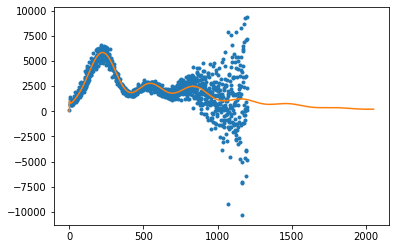

In [47]:
plt.ion()

pars = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.')

cmb=get_spectrum(pars)
plt.plot(cmb)
plt.show()

In [48]:
# Only interested in the data
def get_spectrum_2(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    tt=tt[wmap[:,0].astype(int)] #Only take out the part that corresponds with our data
    return tt

In [49]:
# Perform a fit to determine Chi Squared value
y_pred = get_spectrum_2(pars)
y = wmap[:,1]
sig = wmap[:,2]
numerator = (y_pred-y)**2
denominator = sig**2
Chi_sq = np.sum(numerator / denominator)
print('With uncorrelated error, we have chi squared value at:', Chi_sq)
print('This agrees with the given value in the assignment')

With uncorrelated error, we have chi squared value at: 1588.2376532931526
This agrees with the given value in the assignment


# Question 3

In [50]:
# Creating the N matrix from error sigma
N=np.eye(len(y))*sig**2
Ninv=np.eye(len(y))/sig**2

In [51]:
# Creating the A matrix. I don't know how to make it so that it skip the 3rd index so I do it case by case like this
def dA_1(pars, y, x): 
    dA = np.zeros([5,len(y)])
    dA[0,:] = (get_spectrum_2(pars + [pars[0]/x,0,0,0,0,0]) - y)/(pars[0]/x)
    dA[1,:] = (get_spectrum_2(pars + [0,pars[1]/x,0,0,0,0]) - y)/(pars[1]/x)
    dA[2,:] = (get_spectrum_2(pars + [0,0,pars[2]/x,0,0,0]) - y)/(pars[2]/x)
    dA[3,:] = (get_spectrum_2(pars + [0,0,0,0,(pars[4]/x),0]) - y)/(pars[4]/x)
    dA[4,:] = (get_spectrum_2(pars + [0,0,0,0,0,(pars[5]/x)]) - y)/(pars[5]/x)
    return dA.transpose()

In [52]:
# Now on to the Newton's method with the minimizer. The for loop is adapted from the codes in class with some modification

max_iteration = 10;
lam = 1 # Start with pure Newton method
tol = 0.2 


Chi_sq_newt = np.zeros(max_iteration+1) # To keep track of all the Chi Squared over all the steps
Chi_sq_newt[0] = Chi_sq #The first one is the value of Chi Square we have calculated before
y_pred_newt = y_pred;


# The for Loop 
for iter in range(1, max_iteration): # we start from one because 0 is when we calculate chi in question 2
    derivs = dA_1(pars, y_pred_newt, 100)
    resid = y - y_pred_newt #data minus current model
    rhs = derivs.T@(Ninv@resid)
    lhs = derivs.T@Ninv@derivs
    lhs = lhs + lam*np.diag(np.diag(lhs)) # using the minimizer 
    step  = np.linalg.inv(lhs)@rhs # an array of all 5 parameters
    pars = pars + [step[0], step[1], step[2], 0, step[3], step[4]]    
    y_pred_newt = get_spectrum_2(pars)
    numerator = (y_pred_newt - y)**2
    denominator = sig**2
    Chi_sq_newt[iter] = np.sum(numerator / denominator)
    del_Chi = Chi_sq_newt[iter] - Chi_sq_newt[iter - 1] # Calculate the different between 2 chi's
    if np.abs(del_Chi) < tol:
        break 
    lam=lam*2**(del_Chi/100) # update lambda if del_Chi is not small enough and start another iteration


In [53]:
Chi_sq_newt

array([1588.23765329, 1295.44573732, 1234.41531196, 1230.86094211,
       1229.70760772, 1229.13613918, 1228.80361097, 1228.58438631,
       1228.42717297,    0.        ,    0.        ])

In [54]:
pars_newt = pars # copy it, in case we want to trace back pars values  
pars_newt_errs = np.sqrt(np.diag(np.linalg.inv(lhs))) # Error on the parameters just found

In [55]:
print('With optical depth fixed, we found')
print('The hubble constant:', pars_newt[0],', with an error:', pars_newt_errs[0])
print('the physical baryon density:', pars_newt[1],', with an error:', pars_newt_errs[1])
print('the cold dark matter density:', pars_newt[2],', with an error:', pars_newt_errs[2])
print('the primordial amplitude of fluctations:', pars_newt[4],', with an error:', pars_newt_errs[3])
print('the slope of the priomordial power law:', pars_newt[5],', with an error:', pars_newt_errs[4])

With optical depth fixed, we found
The hubble constant: 70.75489312306807 , with an error: 1.1481774003257776
the physical baryon density: 0.02254511160678083 , with an error: 0.00038092534675826013
the cold dark matter density: 0.11031032001621174 , with an error: 0.0018453475955994914
the primordial amplitude of fluctations: 2.016578161076733e-09 , with an error: 1.6059762681337477e-11
the slope of the priomordial power law: 0.9731806262838371 , with an error: 0.008885928383017473


In [56]:
# I don't know how to show the plot for the derivatives so I will go on proving that you should believe
# in my derivatives in a different way. If our dervitives are indeed valid, we should be able to freely vary the step size
# without having any significant change to the chi square
# For this, I am decreasing the step size by 10 to prove this point (100 to 10)
iter = iter + 1 
derivs = dA_1(pars, y_pred_newt, 10) # Here step size has been reduced from 100 to 10
resid = y - y_pred_newt 
rhs = derivs.T@(Ninv@resid)
lhs = derivs.T@Ninv@derivs
lhs = lhs + lam*np.diag(np.diag(lhs)) # using the minimizer 
step  = np.linalg.inv(lhs)@rhs # an array of all 5 parameters
pars = pars + [step[0], step[1], step[2], 0, step[3], step[4]]    
y_pred_newt = get_spectrum_2(pars)
numerator = (y_pred_newt - y)**2
denominator = sig**2
Chi_sq_newt[iter] = np.sum(numerator / denominator)
del_Chi = Chi_sq_newt[iter] - Chi_sq_newt[iter - 1]
print(del_Chi)
print('It is not that much different from the previous Chi squared so my derivative scheme works')

-0.11248253149983611
It is not that much different from the previous Chi squared so my derivative scheme works


If $\tau$ were to be varied, generally speaking we would see an increase in error as we just added another degree of freedom to the our model. However, if $\tau$ is a dominating parameter, allowing it to float might actually reduce the errors on the other parameters as it helps the model work better. 

# Question 4

In [57]:
# Define dA function again for when we also use Tau
def dA_full(pars, y, x):
    dA = np.zeros([len(pars),len(y)])
    dummy = np.zeros(len(pars))
    for i in range(len(pars)):
            dummy[i]=pars[i]/x
            dA[i,:]=(get_spectrum_2(pars + dummy) - y)/(pars[i]/x)
            dummy[i]=0
    return dA.transpose()

In [58]:
def par_step(par,step):
    param_scalings = step*par
    return par + param_scalings*np.random.randn(len(par))
def take_step_cov(covmat):
    mychol = np.linalg.cholesky(covmat)
    return np.dot(mychol,np.random.randn(covmat.shape[0]))

In [59]:
# Now redo again with 
dA = dA_full(pars, y_pred, 100)
lhs =dA.T@Ninv@dA
pars_error = np.linalg.inv(lhs)


In [60]:
# Building a mcmc algorithm like in class. Using chisq value of the last Newton's method
to_do = 0 # we won't run this... It took 4 hours just to run and I have to run it 3 times to find good chain

if to_do == 1:
    chisq = Chi_sq_newt[iter] # The last evaluated chi squared from the Newton's method
    pars = pars_newt

    scale_fac = 0.5
    nstep = 10000
    count = 0 #keep track of the chain iteration
    chain = np.zeros([nstep,len(pars)])
    chisqvec = np.zeros(nstep)
    t = time.time()


    for i in range(nstep):
        new_pars = pars + take_step_cov(pars_error)*scale_fac
        if new_pars[3] > 0:
            y_pred_cmcm = get_spectrum_2(new_pars)
            new_chisq = np.sum((y_pred_cmcm - y)**2 / (sig**2))    
            delta_chisq = new_chisq - chisq
            prob = np.exp(-0.5*delta_chisq)
            accept = np.random.rand(1)
            if accept < prob:
                pars = new_pars
                chisq = new_chisq
                count = count+1
        chain[i,:] = pars
        chisqvec[i] = chisq
        np.savetxt('Q3.csv', chain, delimiter = ',')
    np.savetxt('Q3_final.csv', chain, delimiter = ',') # Save so that I don;t need to run this again...
    print((time.time()-t)/60,'min')
else:
    # It took so long to run so I ran the cell above and saved data and re-called it again
    chain = np.loadtxt('Q3_final_good.csv',delimiter=',') #load here 
    nstep = 10000

run time was 242 mins... I will not runt this cuz it tooks forever to run...

In [61]:
# Calculating pars and its error
pars_mcmc = np.mean(chain,axis=0)
pars_error = np.std(chain,axis=0)/np.sqrt((nstep*.2)/2) 

In [62]:
name = ['Hubble Constant', 'Physical Baryon Density', 'Cold Dark Matter Density', 'Optical Pathlength', 
         'Primordial Amplitude of Fluctations', 'Slope of The Triomordial Power Law']
print('MCMC gave the following results:')
for i in range(len(name)):
    print('The ', name[i], 'is ', pars_mcmc[i], ' with error:', pars_error[i])

MCMC gave the following results:
The  Hubble Constant is  72.7233807385854  with error: 0.11596218355699157
The  Physical Baryon Density is  0.023131893177883573  with error: 2.424806708058767e-05
The  Cold Dark Matter Density is  0.10803947201637938  with error: 0.00020552827519379496
The  Optical Pathlength is  0.1306308442604483  with error: 0.00201331773990426
The  Primordial Amplitude of Fluctations is  2.3823977699100364e-09  with error: 8.712217667659466e-12
The  Slope of The Triomordial Power Law is  0.9921330535689258  with error: 0.0007318246599024863


Now to show that the chain has finally converge, we will show that the last 3000 points just fluctuates around the mean of the value and the fourier transform. The data will be plotted for Hubble constant

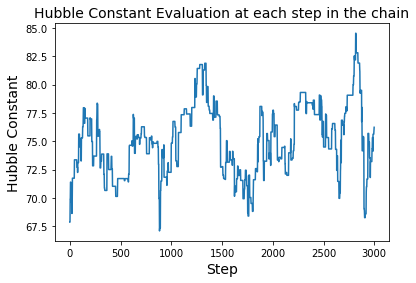

In [63]:
# Plot out the value of some part of the cahin
test = 0
noise = chain[nstep-3000:nstep, test] # to get rid of the bad part at the beginning of the chain
plt.plot(noise, markersize = 10)
plt.ylabel('Hubble Constant', fontsize = 14)
plt.xlabel('Step', fontsize = 14)
plt.title('Hubble Constant Evaluation at each step in the chain', fontsize = 14)
plt.show()

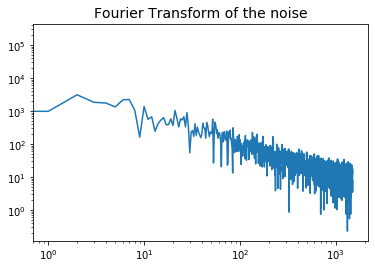

In [64]:
F_noise=np.fft.rfft(noise)
plt.title('Fourier Transform of the noise', fontsize = 14)
plt.loglog(np.abs(F_noise)) 
plt.show()

# Question 5

In [65]:
mu = 0.0544
sig = 0.0073
chain2 = np.zeros([nstep,len(pars)])
pars = chain[0,:]
count = 0

for i in range(len(chain)):
    new_pars = chain[i,:]
    prob = np.exp(-(new_pars[3] - mu)**2/(2*sig**2))
    accept = np.random.rand(1)<prob
    if accept:
        pars = new_pars
        count = count+1
    chain2[i,:] = pars

In [66]:
pars_mcmc_2 = np.mean(chain2, axis = 0)
pars_mcmc_error_2 = np.std(chain2, axis =0)/np.sqrt(count/2) #making an estimate that half the data points are uncorrelated

In [67]:
name = ['Hubble Constant', 'Physical Baryon Density', 'Cold Dark Matter Density', 'Optical Pathlength', 
         'Primordial Amplitude of Fluctations', 'Slope of The Triomordial Power Law']
print('MCMC gave the following results:')
for i in range(len(name)):
    print('The ', name[i], 'is ', pars_mcmc_2[i], ' with error:', pars_mcmc_error_2[i])

MCMC gave the following results:
The  Hubble Constant is  70.67692051148555  with error: 0.1380215589441651
The  Physical Baryon Density is  0.022610174473745668  with error: 2.4208036524001142e-05
The  Cold Dark Matter Density is  0.11139146976042132  with error: 0.000265664267411025
The  Optical Pathlength is  0.06895930978982989  with error: 0.0016865857935764968
The  Primordial Amplitude of Fluctations is  2.110530117943105e-09  with error: 6.504744760042983e-12
The  Slope of The Triomordial Power Law is  0.9743461648195253  with error: 0.0006768334337317059


These results appear to be lower than those of the full chain probbaly because of the difference in optical path length 